In [2]:
import torch
import torch.nn as nn
import torch_geometric
from src.layer.encoders import TrigonometricEncoder
from src.model.wavegc import WaveGCNet
from src.transforms.spectral import WaveGCSpectralTransform

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

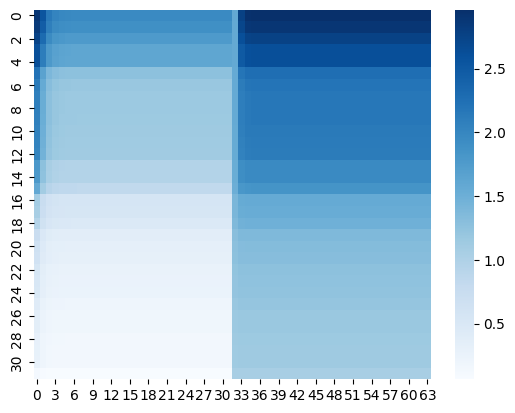

In [3]:
eigvs = torch.tensor(np.random.uniform(0,2, (1, 32) ),
                      dtype=torch.float32).sort(
    axis=1,descending=True).values
d = 64

pe = TrigonometricEncoder(d, 100, project=False)
pos = pe(eigvs)
sns.heatmap(pos.detach(), cmap='Blues')

In [4]:
from src.datasets.amazon import AmazonComputerDataset
from src.datasets.Ps import PeptidesStructDataset
from torch_geometric.utils.convert import to_networkx, from_networkx
import networkx as nx

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = AmazonComputerDataset(root='./data', name='Photo', threshold=0)

TypeError: AmazonComputerDataset.__init__() got an unexpected keyword argument 'threshold'

In [5]:
G = to_networkx(dataset._data)
G = nx.to_undirected(G)
nx.number_connected_components(G)

136

In [6]:
components = nx.connected_components(G)
for comp in components:
    print(len(comp)/G.number_of_nodes())

0.9786928104575163
0.00026143790849673205
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00026143790849673205
0.00013071895424836603
0.00026143790849673205
0.00013071895424836603
0.0005228758169934641
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00026143790849673205
0.00026143790849673205
0.00026143790849673205
0.00013071895424836603
0.00026143790849673205
0.00026143790849673205
0.00013071895424836603
0.000392156862745098
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00026143790849673205
0.00013071895424836603
0.00013071895424836603
0.0005228758169934641
0.00013071895424836603
0.00026143790849673205
0.0005228758169934641
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.00013071895424836603
0.000130718954248366

In [5]:
from torch.utils.data import DataLoader
from src.datasets.collate import collate_fn

In [9]:
loader = DataLoader(dataset=dataset, collate_fn=collate_fn, batch_size=1)

In [11]:
inp_dim = dataset._data.x.shape[1]
emb_dim, pe_dim = 32, 16
eigvs_dim = dataset._data.eigvs.shape[1]
hidden_dim = 32
lape_hidden_num = 1
out_dim = dataset._data.y.unique().shape[0]
K, J = 6, 3

In [12]:
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.nn.conv import MessagePassing

class SimpleGCN(nn.Module):
    def __init__(self, inp_dim, out_dim, hidden_dim, hidden_num=3, **kwargs):
        super().__init__()
        self.inp_dim, self.out_dim = inp_dim, out_dim
        self.hidden_dim = hidden_dim
        act = nn.GELU
        self.conv = nn.ModuleList([pyg_nn.GCN(
                                    in_channels=inp_dim,
                                    hidden_channels=hidden_dim,
                                    num_layers=hidden_num,
                                    act = act(),
                                )])
        for i in range(hidden_num):
            self.conv.append( pyg_nn.GCN(
                    in_channels=hidden_dim,
                    hidden_channels=hidden_dim,
                    num_layers=3,
                    act = act())
            )
            if i!= hidden_num-1:
                self.conv.append(nn.BatchNorm1d(hidden_dim))
                #self.conv.append(act())
        self.out = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x, edge_index, **kwargs):
        for module in self.conv: 
            if isinstance(module, (pyg_nn.GCN, MessagePassing)): 
                x = module(x, edge_index)
            else:
                x = module(x) 
                
        return self.out(x)


In [13]:
import hydra
print(hydra.__version__)

1.3.2


In [14]:
wave_flag = True

In [15]:
model = WaveGCNet(
        inp_dim=inp_dim,
        out_dim=out_dim,
        emb_dim=emb_dim, 
        pe_dim=pe_dim, 
        eigvs_dim=eigvs_dim,
        lape_hidden_num=lape_hidden_num,
        hidden_dim=hidden_dim, 
        heads_num=4,
        scale=torch.tensor([1.0]*J), 
        num_layers=4,
        mpnn="gcn",
        K=K,
        J=J,
        tight_frames=True,
        dropout=0.2,
        ffn_hidden_num=2,
        mpnn_hidden_num=1,
        eps=100,
        aggr="sum",
    ) if wave_flag else SimpleGCN(inp_dim, out_dim, hidden_dim=64)

In [16]:
print("Number of Parameters: ", sum([param.numel() for param in model.parameters()]))

Number of Parameters:  124345


In [6]:
dataset = PeptidesStructDataset(root='./data')

Processing...
c:\Users\DELL\WaveGC\src\datasets\Ps.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_content = torch.load(raw_path)


Processing peptides-struct from geometric_data_processed.pt...
Detected compressed (data, slices) format. Unpacking...
Successfully unpacked 15535 graphs.
Applying Spectral Transform (Calculating Eigenvectors)...
Saving processed data to disk...


Done!
c:\Users\DELL\WaveGC\src\datasets\Ps.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_list = torch.load(path)


In [7]:
import inspect

print(inspect.getsource(collate_fn))

def collate_fn(dataset_items: list):
    """
    Pads spatial dimensions (N) to N_max.
    Stacks spectral dimensions (k) based on the computed pre-transform.
    """
    batch_size = len(dataset_items)

    # 1. Determine Dimensions
    # Spatial: Max nodes in this batch
    max_nodes = max([item.num_nodes for item in dataset_items])

    # Spectral: Max eigenvalues available in this batch
    # (If using fixed top_k in transform, this is constant. If pct, it varies)
    max_k = max([item.eigvs.shape[1] for item in dataset_items])

    feat_dim = dataset_items[0].x.shape[1]

    # 2. Allocate Dense Tensors
    x_padded = torch.zeros((batch_size, max_nodes, feat_dim))
    eigvs_padded = torch.zeros((batch_size, max_k))
    U_padded = torch.zeros((batch_size, max_nodes, max_k))

    train_mask = torch.zeros((batch_size, max_nodes), dtype=torch.bool)
    test_mask = torch.zeros((batch_size, max_nodes), dtype=torch.bool)
    # Mask: True = Padding/Ignored
    eigvs_mask = torch.ones((batc

In [8]:
# Get a single data sample
sample = dataset[0]

# Check what attributes are available
print("Available attributes:", sample.keys)

# View the masks
if hasattr(sample, 'train_mask'):
    print("\nTrain mask:", sample.train_mask)
    print("Train mask shape:", sample.train_mask.shape)
    print("Number of training nodes:", sample.train_mask.sum().item())

if hasattr(sample, 'test_mask'):
    print("\nTest mask:", sample.test_mask)
    print("Test mask shape:", sample.test_mask.shape)
    print("Number of test nodes:", sample.test_mask.sum().item())

if hasattr(sample, 'val_mask'):
    print("\nVal mask:", sample.val_mask)
    print("Val mask shape:", sample.val_mask.shape)
    print("Number of val nodes:", sample.val_mask.sum().item())

# View other useful info
print("\nNumber of nodes:", sample.num_nodes)
print("Number of edges:", sample.num_edges)
print("Node features shape:", sample.x.shape)
print("Edge index shape:", sample.edge_index.shape)

# Check spectral features
if hasattr(sample, 'eigvs'):
    print("\nEigenvalues shape:", sample.eigvs.shape)
if hasattr(sample, 'U'):
    print("Eigenvectors shape:", sample.U.shape)

Available attributes: <bound method BaseData.keys of Data(x=[119, 9], edge_index=[2, 244], y=[1, 11], eigvs=[1, 119], U=[119, 119])>

Number of nodes: 119
Number of edges: 244
Node features shape: torch.Size([119, 9])
Edge index shape: torch.Size([2, 244])

Eigenvalues shape: torch.Size([1, 119])
Eigenvectors shape: torch.Size([119, 119])


In [9]:
# Access the entire list of graphs
data_list = dataset._data_list

print(f"Total number of graphs: {len(data_list)}")

# Access individual graphs
first_graph = data_list[0]
print(f"\nFirst graph:")
print(f"  Nodes: {first_graph.num_nodes}")
print(f"  Edges: {first_graph.num_edges}")
print(f"  Features shape: {first_graph.x.shape}")
print(f"  Label: {first_graph.y}")

# Or iterate through them
for i, graph in enumerate(data_list[:3]):  # First 3 graphs
    print(f"\nGraph {i}:")
    print(f"  Nodes: {graph.num_nodes}")
    print(f"  Label shape: {graph.y.shape}")

Total number of graphs: 15535

First graph:
  Nodes: 119
  Edges: 244
  Features shape: torch.Size([119, 9])
  Label: tensor([[-0.4041, -0.4123, -0.3545, -0.3449, -0.3561, -0.2076, -0.3326,  0.1569,
          0.1774,  0.1596, -0.2671]])

Graph 0:
  Nodes: 119
  Label shape: torch.Size([1, 11])

Graph 1:
  Nodes: 338
  Label shape: torch.Size([1, 11])

Graph 2:
  Nodes: 209
  Label shape: torch.Size([1, 11])
